# Лабораторна робота №5
## виконав 
## Жорник Данило 
## студент групи КН-223с


#  Завдання 
1. Визначити номер варіанта за формулою: N = ord(X) % 5 + 1,
де X – перша велика літера вашого імені в латинській транскрипції.
3. Завантажити дані з файлу lab5.xlsx до датафрейму.
4. Отримати дані до свого варіанту програмно з датафрейму, 
використовуючи інструменти індексування.
5. Створити функцію, що приймає в якості аргументів дані з датафрейму та 
повертає зменшене зображення з доданими «круглими окулярами» та 
зберігає отримане зображення у файл.

Примітки
1. При зменшенні зображення помістити обличчя в центрі картинки.
2. Для визначення обличчя та очей використати Haar Cascade з бібліотеки 
OpenCV.
3. Для малювання використати бібліотеки PIL та/або OpenCV (за бажанням)


In [2]:
N = ord('D') % 5 + 1
print(N)

4


### Варіант №4

Опрацьовуємо рядок номер 1
Опрацьоване зображення збереглось як result_emma-watson2.jpg
Опрацювання зображення для рядка 1 відбулось успішно


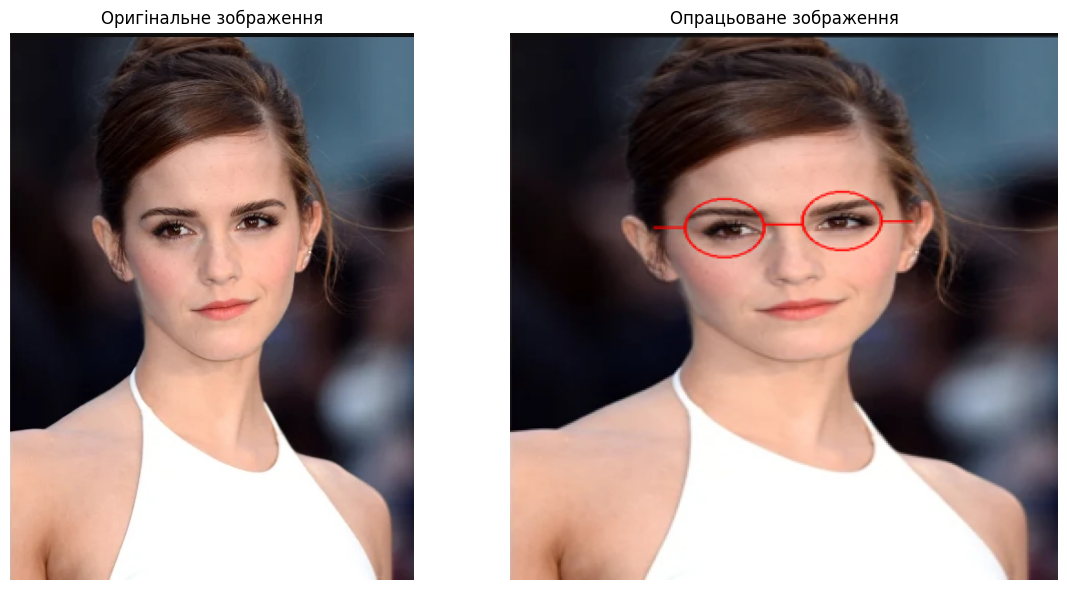

Опрацьовуємо рядок номер 2
Опрацьоване зображення збереглось як result_emma-watson.jpg
Опрацювання зображення для рядка 2 відбулось успішно


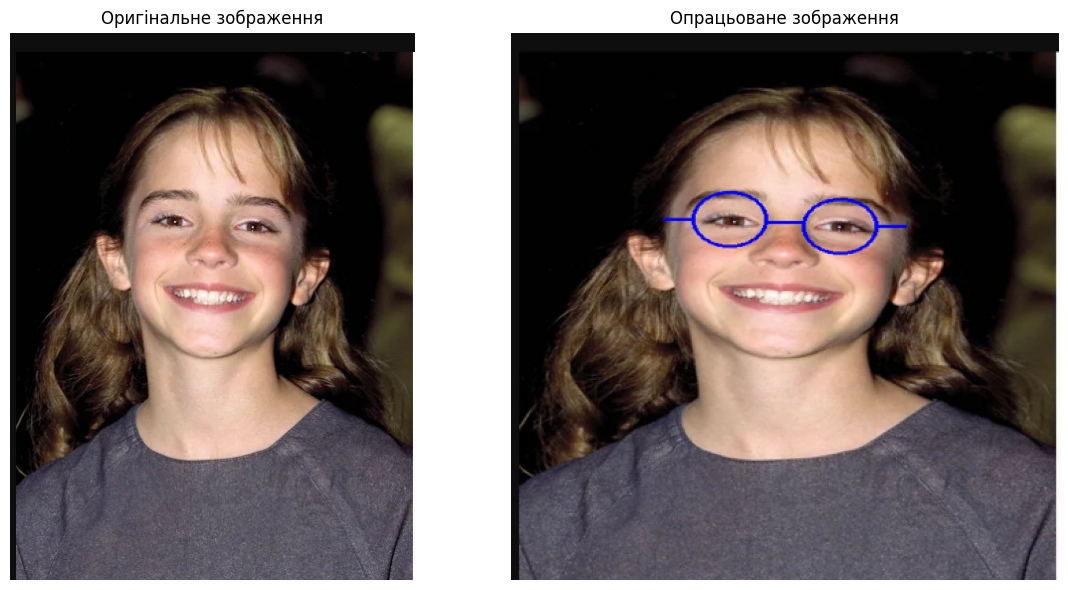

Опрацьовуємо рядок номер 3
Опрацьоване зображення збереглось як result_draco.jpg
Опрацювання зображення для рядка 3 відбулось успішно


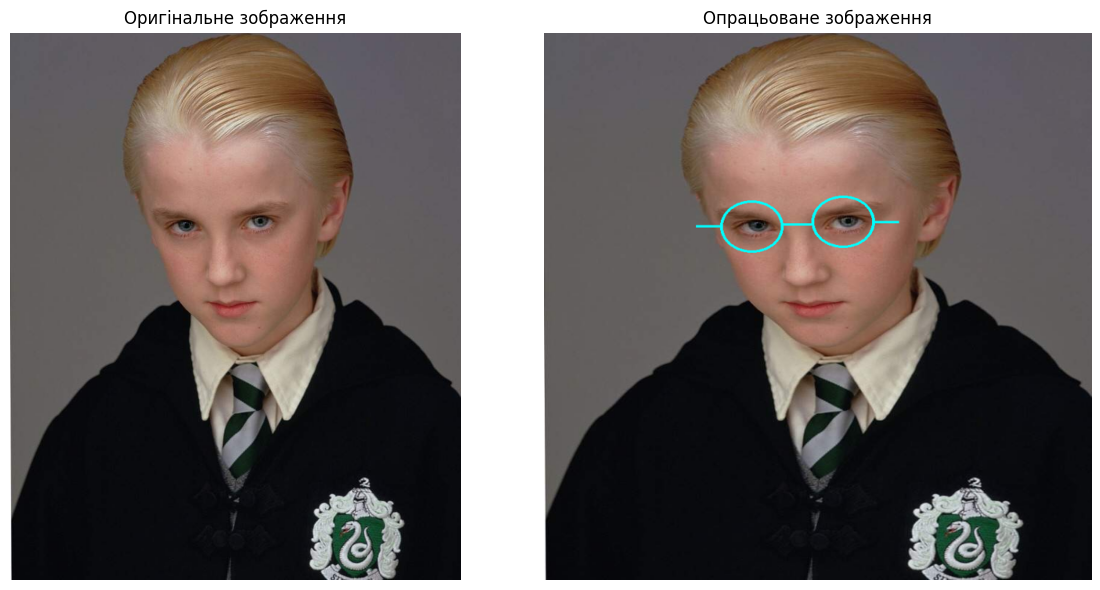

Опрацьовуємо рядок номер 4
Опрацьоване зображення збереглось як result_longbottom.jpg
Опрацювання зображення для рядка 4 відбулось успішно


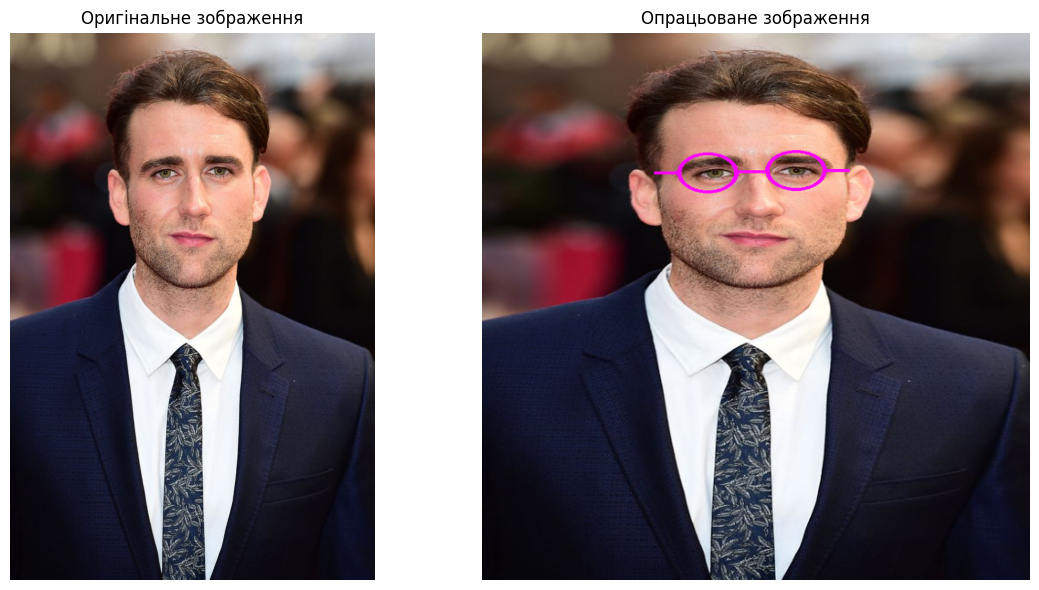

Опрацьовуємо рядок номер 5
Недостатньо очей знайдено
Опрацьоване зображення збереглось як result_ron_wesley.jpg
Опрацювання зображення для рядка 5 відбулось успішно


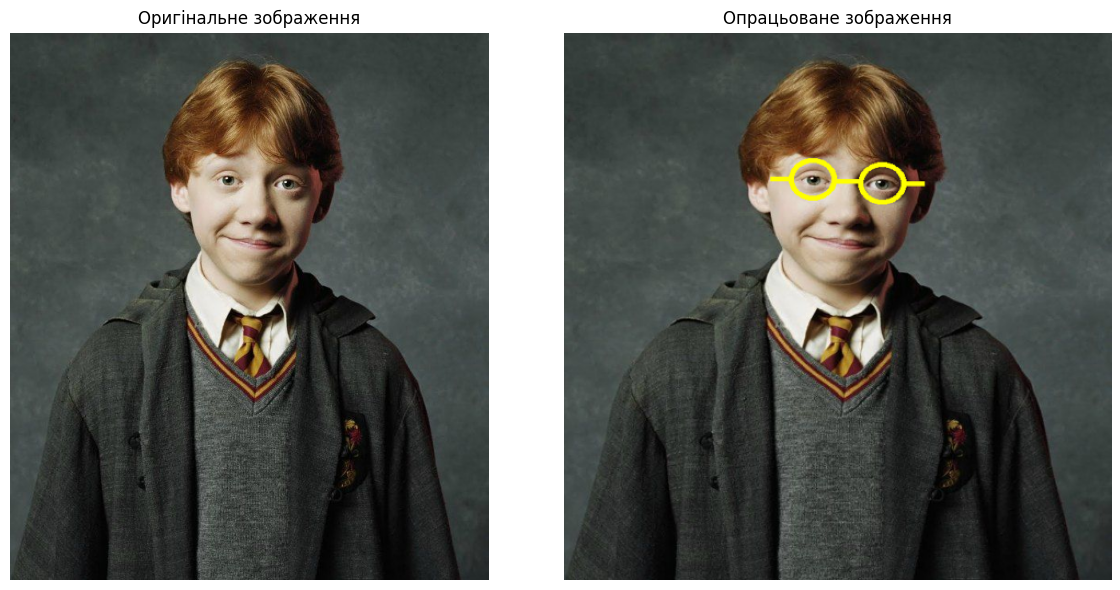

In [27]:
import pandas as pd
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import os
import math
import matplotlib.pyplot as plt

df = pd.read_excel('lab5.xlsx')

def add_round_glasses(image_path, output_size, glasses_color, line_width):
    # Отримуємо повний шлях до файлу зображення
    full_image_path = get_full_image_path(image_path)
    
    # Перевіряємо, чи існує файл зображення
    if not validate_image_path(full_image_path):
        return None, None
    
    # Завантажуємо та перевіряємо зображення
    img, original_img = load_and_check_image(full_image_path)
    if img is None:
        return original_img, None
    
    # Виявляємо обличчя на зображенні
    faces = detect_faces(img)
    if len(faces) == 0:
        return original_img, None
    
    # Витягаємо область обличчя
    face_region = get_face_region(img, faces[0], 2)
    
    # Виявляємо очі в області обличчя
    eyes = detect_eyes(face_region)
    if len(eyes) < 2:
        face_region_full = get_face_region(img, faces[0], 1)
        eyes = detect_eyes(face_region_full)
        if len(eyes) < 2:
            return original_img, None

    # Сортуємо очі за положенням на зображенні
    left_eye, right_eye = sort_eyes(eyes)
    
    # Обчислюємо центри очей
    left_eye_center, right_eye_center = get_eye_centers(left_eye, right_eye, faces[0])

    # Малюємо окуляри на зображенні
    pil_img = draw_glasses(img, left_eye_center, right_eye_center, glasses_color, line_width)

    if pil_img is None:
        return original_img, None

    # Змінюємо розмір та зберігаємо оброблене зображення
    resized_image = resize_and_save_image(pil_img, output_size, image_path)
    
    return original_img, resized_image


def get_full_image_path(image_path):
    # Створюємо повний шлях до файлу зображення, додаючи папку "Images"
    return os.path.join("Images", image_path)


def validate_image_path(full_image_path):
    # Перевіряємо, чи існує файл за вказаним шляхом
    if not os.path.exists(full_image_path):
        print(f"Error: The file {full_image_path} does not exist.")
        return False
    return True


def load_and_check_image(full_image_path):
    # Завантажуємо зображення за допомогою OpenCV
    img = cv2.imread(full_image_path)
    if img is None:
        print(f"Неможливо зчитати зображення {full_image_path}")
        return None, None
    # Конвертуємо зображення у формат RGB для подальшої обробки у PIL
    original_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return img, original_img


def detect_faces(img):
    # Конвертуємо зображення у відтінки сірого
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Використовуємо каскад Хаара для виявлення обличчя
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))
    if len(faces) == 0:
        print("Обличчя не виявлено")
    return faces


def get_face_region(img, face, mod):
    # Витягаємо верхню частину обличчя з зображення
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x, y, w, h = face
    return gray[y:y + h//mod, x:x + w]


def detect_eyes(face_region):
    # Використовуємо каскад Хаара для виявлення очей у виділеній області обличчя
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(face_region, scaleFactor=1.1, minNeighbors=10, minSize=(10, 10))
    if len(eyes) < 2:
        print("Недостатньо очей знайдено")
    return eyes


def sort_eyes(eyes):
    # Сортуємо знайдені очі за їхнім положенням на зображенні (зліва направо)
    return sorted(eyes, key=lambda e: e[0])[:2]


def get_eye_centers(left_eye, right_eye, face):
    # Обчислюємо центри лівого та правого ока
    x, y, _, _ = face
    left_eye_center = (x + left_eye[0] + left_eye[2] // 2, y + left_eye[1] + left_eye[3] // 2)
    right_eye_center = (x + right_eye[0] + right_eye[2] // 2, y + right_eye[1] + right_eye[3] // 2)
    return left_eye_center, right_eye_center


def draw_glasses(img, left_eye_center, right_eye_center, glasses_color, line_width):
    try:
        # Конвертуємо зображення в PIL формат для малювання
        pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_img)
        
        # Обчислюємо відстань між очима та радіус окулярів
        eye_distance = np.sqrt((right_eye_center[0] - left_eye_center[0])**2 + 
                               (right_eye_center[1] - left_eye_center[1])**2)
        lens_radius = int(eye_distance * 0.35)

        # Малюємо круглі окуляри навколо очей
        draw.ellipse([left_eye_center[0] - lens_radius, left_eye_center[1] - lens_radius,
                      left_eye_center[0] + lens_radius, left_eye_center[1] + lens_radius],
                     outline=glasses_color, width=line_width)

        draw.ellipse([right_eye_center[0] - lens_radius, right_eye_center[1] - lens_radius,
                      right_eye_center[0] + lens_radius, right_eye_center[1] + lens_radius],
                     outline=glasses_color, width=line_width)

        # Малюємо місток окулярів і дужки
        draw_bridge(draw, left_eye_center, right_eye_center, lens_radius, glasses_color, line_width)
        draw_temples(draw, left_eye_center, right_eye_center, lens_radius, eye_distance, glasses_color, line_width)

        return pil_img
    
    except ValueError as e:
        print(f"Error: Invalid color '{glasses_color}'. {str(e)}")
        return None


def draw_bridge(draw, left_eye_center, right_eye_center, lens_radius, glasses_color, line_width):
    # Малюємо місток окулярів між лінзами
    bridge_y = (left_eye_center[1] + right_eye_center[1]) // 2
    draw.line([left_eye_center[0] + lens_radius, bridge_y,
               right_eye_center[0] - lens_radius, bridge_y],
              fill=glasses_color, width=line_width)


def draw_temples(draw, left_eye_center, right_eye_center, lens_radius, eye_distance, glasses_color, line_width):
    # Малюємо дужки окулярів, що йдуть до скронь
    temple_length = int(eye_distance * 0.8) // 3

    left_temple_end = (
        left_eye_center[0] - lens_radius - temple_length,  # Зміщення по горизонталі
        left_eye_center[1]  # Та сама координата по вертикалі
    )
    
    draw.line([left_eye_center[0] - lens_radius, left_eye_center[1],
               left_temple_end[0], left_temple_end[1]],
              fill=glasses_color, width=line_width)

    right_temple_end = (
        right_eye_center[0] + lens_radius + temple_length,  # Зміщення по горизонталі
        right_eye_center[1]  # Та сама координата по вертикалі
    )

    draw.line([right_eye_center[0] + lens_radius, right_eye_center[1],
               right_temple_end[0], right_temple_end[1]],
              fill=glasses_color, width=line_width)


def resize_and_save_image(pil_img, output_size, image_path):
    # Змінюємо розмір зображення до заданих розмірів
    pil_img = pil_img.resize((output_size, output_size))
    
    # Зберігаємо оброблене зображення у вихідний файл
    output_path = f"result_{os.path.basename(image_path)}"
    pil_img.save(output_path)
    print(f"Опрацьоване зображення збереглось як {output_path}")
    
    return pil_img


# N = ord('D') % 5 + 1
# print(f"Опрацьовуємо рядок номер {N}")

# row = df.iloc[N - 1]
# image_path = row['file name']
# output_size = int(row['image size'].split('x')[0]) 
# glasses_color = row['glasses color']
# line_width = row['line width']

# original_img, result_img = add_round_glasses(image_path, output_size, glasses_color, line_width)

# if original_img is not None and result_img is not None:
#     print("Опрацювання зображення відбулось успішно")
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
#     ax1.imshow(original_img)
#     ax1.set_title('Оригінальне зображення')
#     ax1.axis('off')
    
#     ax2.imshow(result_img)
#     ax2.set_title('Опрацьоване зображення')
#     ax2.axis('off')
    
#     plt.tight_layout()
#     plt.show()

for N in range(1, 6):
    print(f"Опрацьовуємо рядок номер {N}")
    
    row = df.iloc[N - 1]
    image_path = row['file name']
    output_size = int(row['image size'].split('x')[0]) 
    glasses_color = row['glasses color']
    line_width = row['line width']

    original_img, result_img = add_round_glasses(image_path, output_size, glasses_color, line_width)

    if original_img is not None and result_img is not None:
        print(f"Опрацювання зображення для рядка {N} відбулось успішно")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(original_img)
        ax1.set_title('Оригінальне зображення')
        ax1.axis('off')

        ax2.imshow(result_img)
        ax2.set_title('Опрацьоване зображення')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Опрацювання зображення для рядка {N} не вдалося")
